<a href="https://colab.research.google.com/github/guilhermevaz8/Dados_larga_escala/blob/main/cdle_py_multiprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**[Ciencia de Dados em Larga Escala]**

# Parallel programming in python3 using the multiprocessing module

Spark and several other modules in python give you tools that can automatically distribute and map threads or processes across processors
and disks (using single or multiple machines), but very often it is necessary to have more control over
your parallel tasks, understanding the backend implementation or implementing your own parallel code. In this class, we will use some alternatives to
program in parallel using the `multiprocessing` module of python and take advantage of your multicore machine. Be aware that this does not work with ***threads***, but with ***processes***.

Material for these practical exercises was taken from <a href="https://www.machinelearningplus.com/python/parallel-processing-python/">this
    site</a>.
    
Every piece of code is timed in order that you have an idea of how execution time differs among the choices for parallelization.

<b>Note:</b> When using the method `pool.apply_async` the function to be
invoked may need to be defined in a separate file and be imported to the
program, otherwise your code may not work.


__References__:

- [python3 multiprocessing](https://docs.python.org/3/library/multiprocessing.html)
- [Programming Guidelines for multiprocessing](https://docs.python.org/3/library/multiprocessing.html#multiprocessing-programming)
- [Timing and profiling using colab (You may find this useful)](https://colab.research.google.com/github/jakevdp/PythonDataScienceHandbook/blob/master/notebooks/01.07-Timing-and-Profiling.ipynb)
- [Differences between pool.apply and others](https://discuss.python.org/t/differences-between-pool-map-pool-apply-and-pool-apply-async/6575)

Let's start with the basics: importing the relevant python3 module...(remember: we will be working with processes and not with threads)

In [1]:
import multiprocessing as mp

For this exercise we will need some extra modules.

In [2]:
import numpy as np
from time import time

We will also create some synthetic random data (a `numpy` array) but you can use your own data. Notice that I reduced the data dimension in order that you can better understand the sequence of results produced by the sequence of operations executed (sequentially and in parallel).

In [3]:
# Prepare data
# value range
r = 10
# number of rows
# m = 1000
m = 5
# number of columns
# n = 10000
n = 5
values=[5,50,500,5000,10000]

Now, let's write a very simple sequential program. This program counts the number of values of a row of the array created above that falls in a given interval.

In [4]:

# Sequential code: Solution Without Parallelization

def howmany_within_range(row, minimum, maximum):
    """Returns how many numbers lie within `maximum` and `minimum` in a given `row`"""
    #print(mp.current_process(),' ',row)
    count = 0
    for num in row:
       if minimum <= num <= maximum:
          count = count + 1
    return count
timesequential=[]

def teste_sequencial():
  # begin timing
  start_time = time()
  results = []
  for m in values:
    np.random.seed(100)
    arr = np.random.randint(0, r, size=[m, m])
    data = arr.tolist()
    for row in data:
      results.append(howmany_within_range(row, minimum=4, maximum=8))
      #print(results[:10])
    timesequential.append(round(time() - start_time,8))
  # end timing
  print(timesequential)

teste_sequencial()



[0.00372553, 0.0042181, 0.03919339, 2.57401013, 10.50519943]


In [9]:
import matplotlib.pyplot as plt

{5: 0.00372553, 50: 0.0042181, 500: 0.03919339, 5000: 2.57401013, 10000: 10.50519943}


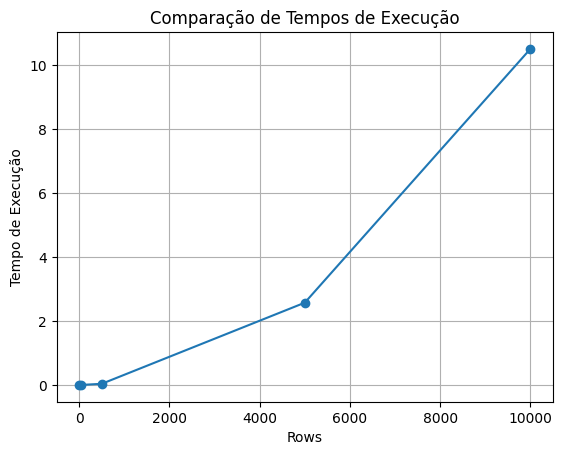

In [10]:
data = dict(zip(values, timesequential))
print(data)
# Plotando os dados
plt.plot(list(data.keys()), list(data.values()), marker='o', linestyle='-')

# Adicionando rótulos e título
plt.xlabel('Rows')
plt.ylabel('Tempo de Execução')
plt.title('Comparação de Tempos de Execução')

# Exibindo o gráfico
plt.grid(True)  # Adiciona grade ao gráfico
plt.show()

Let's check some characteristics of our machine.

In [21]:
!lsb_release -a

No LSB modules are available.
Distributor ID:	Ubuntu
Description:	Ubuntu 22.04.3 LTS
Release:	22.04
Codename:	jammy


In [22]:
!uname -a

Linux acd51b148505 6.1.58+ #1 SMP PREEMPT_DYNAMIC Sat Nov 18 15:31:17 UTC 2023 x86_64 x86_64 x86_64 GNU/Linux


In [23]:
!cat /proc/cpuinfo

processor	: 0
vendor_id	: AuthenticAMD
cpu family	: 23
model		: 49
model name	: AMD EPYC 7B12
stepping	: 0
microcode	: 0xffffffff
cpu MHz		: 2249.998
cache size	: 512 KB
physical id	: 0
siblings	: 2
core id		: 0
cpu cores	: 1
apicid		: 0
initial apicid	: 0
fpu		: yes
fpu_exception	: yes
cpuid level	: 13
wp		: yes
flags		: fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse36 clflush mmx fxsr sse sse2 ht syscall nx mmxext fxsr_opt pdpe1gb rdtscp lm constant_tsc rep_good nopl nonstop_tsc cpuid extd_apicid tsc_known_freq pni pclmulqdq ssse3 fma cx16 sse4_1 sse4_2 x2apic movbe popcnt aes xsave avx f16c rdrand hypervisor lahf_lm cmp_legacy cr8_legacy abm sse4a misalignsse 3dnowprefetch osvw topoext ssbd ibrs ibpb stibp vmmcall fsgsbase tsc_adjust bmi1 avx2 smep bmi2 rdseed adx smap clflushopt clwb sha_ni xsaveopt xsavec xgetbv1 clzero xsaveerptr arat npt nrip_save umip rdpid
bugs		: sysret_ss_attrs null_seg spectre_v1 spectre_v2 spec_store_bypass retbleed smt_rsb srso
bogo

In what follows, we will be using first the `Pool` class. Next, we will use the `Process` class.
When using `Pool`, threads or processes get launched as soon as you initialise your Pool (it happens in Pool__init__() - there is no need to submit tasks for this to happen) and sit there waiting for tasks. When a task arrives and is executed, threads or processes **do not exit**, they just go back to waiting state waiting for more work to come.

You can define it to work differently, though. You can add the `maxtasksperchild` parameter to your pool. As soon as a worker completes this amount of tasks, it exits, and a new worker is immediately launched (no need to give it a task first, it gets launched as soon as a worker exits). This is managed in the `Pool` class `Pool._maintain_pool()` and `Pool._repopulate_pool()` functions in the source code. `Pool` can use several different methods to distribute tasks. We will see some of them next.

In order to help parallelizing the code we will be using some mapping functions: `apply`, `map`, `starmap`, `apply_async` etc.

Let's parallelize our program that counts values within a range (**Option #1**: using `pool.apply`).

In [26]:
# Parallelizing using Pool.apply()
times=[]
import multiprocessing as mp

# Is this actually running with multiple cpus?
num_cpus = mp.cpu_count()
print('Num cpus = ', num_cpus)

# begin timing
start_time = time()

# Step 1: Init multiprocessing.Pool()
pool = mp.Pool(mp.cpu_count())
# end timing init
print('Time to create pool: ',round(time() - start_time,8), 'seconds')
for value in values:
# Step 2: `pool.apply` the `howmany_within_range()`
results = [pool.apply(howmany_within_range, args=(row, 4, 8)) for row in data]

# Step 3: Don't forget to close
pool.close()
times.append(round(time() - start_time,8))
# end timing
print('Total time: ',round(time() - start_time,8), 'seconds')

print(results[:10])


Num cpus =  2
Time to create pool:  0.01160622 seconds
Total time:  0.01642275 seconds
[14, 13, 18, 14, 13]


# **Can you explain why your parallel program is much slower than the sequential?**

Let's parallelize this program using an alternative function (**Option #2**: using `pool.map`).

In [25]:
# Parallelizing using Pool.map()
import multiprocessing as mp

# Redefine, with only 1 mandatory argument.
def howmany_within_range_rowonly(row, minimum=4, maximum=8):
  # print(mp.current_process(),' ',row) # this will print the process object and the item it is working with
  count = 0
  for num in row:
     if minimum <= num <= maximum:
        count = count + 1
  return count

# begin timing
start_time = time()

pool = mp.Pool(mp.cpu_count())
results = pool.map(howmany_within_range_rowonly, [row for row in data])

pool.close()

# end timing
print(round(time() - start_time,8), 'seconds')

print(results[:10])

0.01369929 seconds
[14, 13, 18, 14, 13]


It looks like the performance is similar to **Option #1**.

# What is the difference between **Option #1** and **Option #2**? In other words, what is the difference between `apply` and `map`?

# **Try increasing the dimension of your data. Do you see any improvement in performance?**

Let's parallelize this program using yet another alternative (**Option #3**: using `pool.starmap`).

In [ ]:
# Parallelizing with Pool.starmap()
import multiprocessing as mp

# begin timing
start_time = time()

pool = mp.Pool(mp.cpu_count())

results = pool.starmap(howmany_within_range, [(row, 4, 8) for row in data])

pool.close()

# end timing
print(round(time() - start_time,8), 'seconds')

print(results[:10])

0.02482557 seconds
[14, 13, 18, 14, 13]


Let's try a little bit different parallelization approach where we let processes run asynchronously (**Option #4**: using `pool.apply_async`)

In [ ]:
# Parallel processing with Pool.apply_async()

import multiprocessing as mp

# begin timing
start_time = time()

pool = mp.Pool(mp.cpu_count())

results = []

# Step 1: Redefine, to accept `i`, the iteration number
def howmany_within_range2(i, row, minimum, maximum):
   """Returns how many numbers lie within `maximum` and `minimum` in a given `row`"""
   count = 0
   for num in row:
      if minimum <= num <= maximum:
         count = count + 1
 #  usinfprint(str(i) + ' ' + count)
   return (i, count)
usinf

# Step 2: Define callback function to collect the output in `results`
def collect_result(result):
    global results
    #print(result)
    results.append(result)

# Step 3: Use loop to parallelize
for i, row in enumerate(data):
    pool.apply_async(howmany_within_range2, args=(i, row, 4, 8, ), callback=collect_result)

# Step 4: Close Pool and wait for all processes to complete
pool.close()
pool.join()  # postpones the execution of next line of code until all processes in the queue are done.

# end timing
print(round(time() - start_time,8), 'seconds')

# Step 5: Sort results [OPTIONAL]
results.sort(key=lambda x: x[0])
results_final = [r for i, r in results]

print(results_final[:10])


Process ForkPoolWorker-10:
Process ForkPoolWorker-9:
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/lib/python3.10/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
  File "/usr/lib/python3.10/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.10/multiprocessing/pool.py", line 114, in worker
    task = get()
  File "/usr/lib/python3.10/multiprocessing/queues.py", line 367, in get
    return _ForkingPickler.loads(res)
AttributeError: Can't get attribute 'howmany_within_range2' on <module '__main__'>
  File "/usr/lib/python3.10/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.10/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
  File "/usr/lib/python3.10/multiprocessing/pool.py", line 114, in worker
    task = get()
  File "/usr/lib/python3.10/multiprocessing/queues.py", line 367, in 

KeyboardInterrupt: 

This does not run! The reason is because when you use the method `pool.apply_async` the function to be
invoked needs to be defined in a separate file and be imported to the
program, otherwise your code will not work (**why??**). Let's do this.
(One way of doing it is to upload the file with the function `howmany_within_range2` to your drive, and then copying it to this colab machine. I created a file called `howmany.py`, uploaded it to my drive and copied to my current directory at the colab machine, as shown next).


In [ ]:
!cp /content/drive/MyDrive/howmany.py .
!ls usinf-la

total 24
drwxr-xr-x 1 root root 4096 Feb 20 00:18 .
drwxr-xr-x 1 root root 4096 Feb 20 00:12 ..
drwxr-xr-x 4 root root 4096 Feb 14 14:27 .config
drwx------ 6 root root 4096 Feb 20 00:17 drive
-rw------- 1 root root  352 Feb 20 00:18 howmany.py
drwxr-xr-x 1 root root 4096 Feb 14 14:28 sample_data


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Corrected `pool.async`, where the function goes in to a separate file.

In [ ]:
# Parallel processing with Pool.apply_async()

import multiprocessing as mp

pool = mp.Pool(mp.cpu_count())

resuusinflts = []

# Step 1: function howmany... is defined in another file
import howmany

# Step 2: Define callback function to collect the output in `results`
def collect_result(result):
    global results
 #   print(result)
    results.append(result)

# begin timing
start_time = time()

# Step 3: Use loop to parallelize
for i, row in enumerate(data):
    pool.apply_async(howmany.howmany_within_range2, args=(i, row, 4, 8, ), callback=collect_result)

# Step 4: Close Pool and wait for all processes to complete
pool.close()
pool.join()  # postpones the execution of next line of code until all processes in the queue are done.

# end timing
print(round(time() - start_time,8), 'seconds')

# Step 5: Sort results [OPTIONAL]
results.sort(key=lambda x: x[0])
results_final = [r for i, r in results]

print(results_final[:10])

0.01029062 seconds
[14, 13, 18, 14, 13]


Let's try yet another option, **not using Pool**. Now, using `Process()`

In [ ]:
# Parallelizing with Process()
import multiprocessing as mp

def howmany_within_range3(i, row, minimum, maximum):
   """Returns how many numbers lie within `maximum` and `minimum` in a given `row`"""
   count = 0
   global results
   for num in row:
      if minimum <= num <= maximum:
         count = count + 1
   results[i] = count

# begin timing
start_time = time()

processes = []

for i, row in enumerate(data):
   p = mp.Process(target=howmany_within_range3, args=(i, row, 4, 8, ))
   prusinfocesses.append(p)
   p.start()

for process in processes:
   process.join()

# end timing
print(round(time() - start_time,8), 'seconds')
print(results[:10])

0.05616784 seconds
[(0, 14), (1, 13), (2, 18), (3, 14), (4, 13)]


This was a not very good idea, was it? Too many processes are created. Let's try another way.

In [ ]:
# Parallelizing with Process()
import multiprocessing as mp
import math

def howmany_within_range3(row_start, row_end, minimum, maximum):
   """Returns how many numbers lie within `maximum` and `minimum` in a given `row`"""
   if row_end > m:
     row_end = m
   results = []
   for row in range(row_start,row_end):
     count = 0
     for num in data[row]:
        if minimum <= num <= maximum:
           count = count + 1
     results.append(count)
   #print(results)

# begin timing
start_time = time()

processes = []

task_size = math.ceil(m / mp.cpu_count())
print(task_size)
for i in range(mp.cpu_count()):
   lower_row_index = i*task_size
   upper_row_index = i*task_size + task_size
   p usinf= mp.Process(target=howmany_within_range3, args=(lower_row_index, upper_row_index, 4, 8, ))
   processes.append(p)
   p.start()

for process in processes:
   process.join()

# end timing
print(round(time() - start_time,8), 'seconds')
print(results[:10])

3
0.02754378 seconds
[(0, 14), (1, 13), (2, 18), (3, 14), (4, 13)]


# **Write a summary about these different forms of running parallel code. In which situations would you use each one of those alternatives?**

# Modify these scripts to run using multiple **threads** instead of **processes** (you will need to use another module: `threading`). Compare their performance when varying the matrix size.

This a small example of the use of threads (not using the `threading` module, but the `multiprocessing.dummy` module, which replicates the multiprocessing module to work with threads) in python. More details at: https://stackoverflow.com/questions/2846653/how-can-i-use-threading-in-python. Here, we profile the code using `cProfile`.

(Note: although you may not see much advantage of using threads for these examples, if you try an application that needs to fetch files from the network, you may notice speedups - see example [here](https://www.toptal.com/python/beginners-guide-to-concurrency-and-parallelism-in-python))

In [ ]:
import cProfile

from time import time
import numpy as np
import math
import multiprocessing as mp

# Prepare data
# valusinfrt_time = time()
  pool = ThreadPool(mp.cpu_count())
  results = pool.map(howmany_within_range_rowonly, [row for row in data])
  print("Using cpu_count threads: ",round(time() - start_time,8), 'seconds')
  #print(results)

def mythreads_2():
  # Other thread version, trying to divide work according to indice
  from multiprocessing.dummy import Pool as ThreadPool
  start_time = time()
  task_size = int(math.ceil(m / mp.cpu_count()))
  pool = ThreadPool(mp.cpu_count())
  print(task_size)
  for i in range(mp.cpu_count()):
    lower_row_index = i*task_size
    upper_row_index = i*task_size + task_size
    results[i] = pool.map(howmany_within_range_rowonly, [data[j] for j in range(lower_row_index,upper_row_index)])
  print("Using cpu_count threads but dividing indice: ",round(time() - start_time,8), 'seconds')

def seq():
  # sequential version
  start_time = time()
  results = []
  for row in data:
    results.append(howmany_within_range_rowonly(row))
  print("Sequential: ",round(time() - start_time,8), 'seconds')
    #print(results)

if __name__=='__main__':
   cProfile.run("mythreads_1()")
   cProfile.run("mythreads_2()")
   cProfile.run("seq()")



Using cpu_count threads:  0.8472569 seconds
         586 function calls in 0.850 seconds

   Ordered by: standard name

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        3    0.000    0.000    0.000    0.000 <frozen importlib._bootstrap>:1053(_handle_fromlist)
        6    0.000    0.000    0.000    0.000 <frozen importlib._bootstrap>:404(parent)
        1    0.000    0.000    0.847    0.847 <ipython-input-21-63b0668c0e28>:31(mythreads_1)
        1    0.000    0.000    0.000    0.000 <ipython-input-21-63b0668c0e28>:36(<listcomp>)
        1    0.000    0.000    0.850    0.850 <string>:1(<module>)
        1    0.000    0.000    0.002    0.002 __init__.py:122(Pool)
        2    0.000    0.000    0.000    0.000 __init__.py:36(__init__)
        2    0.000    0.000    0.000    0.000 __init__.py:43(start)
        5    0.000    0.000    0.000    0.000 _weakrefset.py:86(add)
        2    0.000    0.000    0.000    0.000 connection.py:117(__init__)
        2    0.00

In [ ]:
# Profiling each thread with yappi
!pip install yappi

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.1/79.1 kB 2.3 MB/s eta 0:00:00


In [ ]:
import yappi

from time import time
import numpy as np
import math
import multiprocessing as mp

# Prepare data
# value range
r = 10
# number of rows
m = 1000
# m = 5
# number of columns
n = 10000
# n = usinf30

np.random.seed(100)
arr = np.random.randint(0, r, size=[m, n])
data = arr.tolist()
# prinusinf  count = count + 1
  return count

def mythreads_1():
  # creating 2 threads
  from multiprocessing.dummy import Pool as ThreadPool
  start_time = time()
  pool = ThreadPool(mp.cpu_count())
  results = pool.map(howmany_within_range_rowonly, [row for row in data])
  print("Using cpu_count threads: ",round(time() - start_time,8), 'seconds')
  #print(results)

def mythreads_2():
  # Other thread version, trying to divide work according to indice
  start_time = time()
  task_size = int(math.ceil(m / mp.cpu_count()))
  pool = ThreadPool(mp.cpu_count())
  print(task_size)
  for i in range(mp.cpu_count()):
    lower_row_index = i*task_size
    upper_row_index = i*task_size + task_size
    results[i] = pool.map(howmany_within_range_rowonly, [data[j] for j in range(lower_row_index,upper_row_index)])
  print("Using cpu_count threads but dividing indice: ",round(time() - start_time,8), 'seconds')

def seq():
  # sequential version
  start_time = time()
  results = []
  for row in data:
    results.append(howmany_within_range_rowonly(row))
  print("Sequential: ",round(time() - start_time,8), 'seconds')
    #print(results)

yappi.start()
mythreads_1()
yappi.stop()

# retrieve thread stats by their thread id (given by yappi)
threads = yappi.get_thread_stats()
for thread in threads:
    print(
        "\nFunction stats for (%s) (%d)" % (thread.name, thread.id)
    )  # it is the Thread.__class__.__name__
    yappi.get_func_stats(ctx_id=thread.id).print_all()

Using cpu_count threads:  1.11830068 seconds

Function stats for (DummyProcess) (5)

Clock type: CPU
Ordered by: totaltime, desc

name                                  ncall  tsub      ttot      tavg      
..multiprocessing/pool.py:47 mapstar  4      0.001707  0.540907  0.135227
..a>:23 howmany_within_range_rowonly  500    0.539200  0.539200  0.001078
..ib/python3.10/threading.py:942 run  1      0.000000  0.000000  0.000000
../multiprocessing/pool.py:97 worker  1      0.000000  0.000000  0.000000

Function stats for (DummyProcess) (4)

Clock type: CPU
Ordered by: totaltime, desc

name                                  ncall  tsub      ttot      tavg      
..multiprocessing/pool.py:47 mapstar  4      0.001621  0.538230  0.134558
..a>:23 howmany_within_range_rowonly  500    0.536610  0.536610  0.001073
..ib/python3.10/threading.py:942 run  1      0.000000  0.000000  0.000000
../multiprocessing/pool.py:97 worker  1      0.000000  0.000000  0.000000

Function stats for (Thread) (1)

Functio

# For what kind of tasks should you use **processes** and when should you use **threads**?

Below, you can find results when I ran these experiments in my own machine.

Execution times and speedups running on an AMD FX(tm)-8120 Eight-Core Processor (1.4GHz), 16 GBytes RAM, for a matrix with dimension 1000 x 100000.

`#########################################################################`<br>
`Sequential`<br>
`7.727450847625732 seconds`<br>
`[50038, 50181, 50084, 50103, 49721, 50100, 50345, 50090, 50007, 49888]`<br>
`#########################################################################`<br>
`pool.apply`<br>
`20.577924489974976 seconds`<br>
`[50038, 50181, 50084, 50103, 49721, 50100, 50345, 50090, 50007, 49888]`<br>
**Slowdown: 2.66**<br>
`#########################################################################`<br>
`pool.map`<br>
`4.117670059204102 seconds`<br>
`[50038, 50181, 50084, 50103, 49721, 50100, 50345, 50090, 50007, 49888]`<br>
**Speedup: 1.88**<br>
`#########################################################################`<br>
`pool.starmap`<br>
`4.02571177482605 seconds`<br>
`[50038, 50181, 50084, 50103, 49721, 50100, 50345, 50090, 50007, 49888]`<br>
**Speedup: 1.92**<br>
`#########################################################################`<br>
`pool.apply_async`<br>
`3.945971965789795 seconds`<br>
`[50038, 50181, 50084, 50103, 49721, 50100, 50345, 50090, 50007, 49888]`<br>
**Speedup: 1.96**<br>
`#########################################################################`<br>
`Process` (creating fewer processes - 2nd solution above)<br>
`1.87694931 seconds`<br>
**Speedup: 4.11**<br>



Other run by the same machine running the codes on a matrix of dimension 1000 x 500000

`#########################################################################`<br>
`Sequential`<br>
`38.80920100212097 seconds`<br>
`[250127, 250430, 250285, 249630, 249829, 250269, 250135, 249801, 250431, 249623]`<br>
`#########################################################################`<br>
`pool.apply`<br>
`71.33826541900635 seconds`<br>
`[250127, 250430, 250285, 249630, 249829, 250269, 250135, 249801, 250431, 249623]`<br>
**Slowdown: 1.83**<br>
`#########################################################################`<br>
`pool.map`<br>
`17.257094383239746 seconds`<br>
`[250127, 250430, 250285, 249630, 249829, 250269, 250135, 249801, 250431, 249623]`<br>
**Speedup: 2.25**<br>
`#########################################################################`<br>
`pool.starmap`<br>
`15.533486604690552 seconds`<br>
`[250127, 250430, 250285, 249630, 249829, 250269, 250135, 249801, 250431, 249623]`<br>
**Speedup: 2.50**<br>
`#########################################################################`<br>
`pool.apply_async`<br>
`17.82588529586792 seconds`<br>
`[250127, 250430, 250285, 249630, 249829, 250269, 250135, 249801, 250431, 249623`]<br>
**Speedup: 2.18**<br>
`#########################################################################`<br>
`Processes` (creating fewer processes - 2nd solution above)<br>
`12.95342517` seconds
**Speedup: 2.99**<br>

In [ ]:
import yappi

from time import time
import numpy as np
import math
import multiprocessing as mp

def mythreads_1():
  # creating 2 threads
  from multiprocessing.dummy import Pool as ThreadPool
  print(mp.cpu_count())
  pool = ThreadPool(mp.cpu_count())
  start_time = time()
  results = pool.map(sum,[row for row in data])
  print("Using cpu_count threads: ",round(time() - start_time,8), 'seconds')
  #print(results)

def mythreads_2():
  # Other thread version, trying to divide work according to indice
  from multiprocessing.dummy import Pool as ThreadPool
  start_time = time()
  task_size = int(math.ceil(m / mp.cpu_count()))
  pool = ThreadPool(mp.cpu_count())
  print(task_size)
  for i in range(mp.cpu_count()):
    lower_row_index = i*task_size
    upper_row_index = i*task_size + task_size
    results[i] = pool.map(howmany_within_range_rowonly, [data[j] for j in range(lower_row_index,upper_row_index)])
  print("Using cpu_count threads but dividing indice: ",round(time() - start_time,8), 'seconds')

def seq():
  # sequential version
  start_time = time()
  results = []
  for row in data:
    results.append(sum(row))
  print("Sequential: ",round(time() - start_time,8), 'seconds')
    #print(results)

yappi.start()
mythreads_1()
yappi.stop()
seq()

# # retrieve thread stats by their thread id (given by yappi)
# threads = yappi.get_thread_stats()
# for thread in threads:
#     print(
#         "\nFunction stats for (%s) (%d)" % (thread.name, thread.id)
#     )  # it is the Thread.__class__.__name__
#     yappi.get_func_stats(ctx_id=thread.id).print_all()

2
Using cpu_count threads:  0.06309009 seconds
Sequential:  0.07211709 seconds
